# Informe Análisis de Churn TelecomX



## Introducción
En este informe se aborda el problema de evasión de clientes (Churn) en el dataset de TelecomX.  
El objetivo es identificar patrones y factores que influyen en la cancelación del servicio, para proponer acciones estratégicas que reduzcan la tasa de churn.


## 1. Limpieza y Tratamiento de Datos
**Pasos realizados:**
1. Carga del JSON y normalización con `pd.json_normalize()`
2. Estandarización de cadenas (eliminación de espacios y minúsculas)
3. Uniformidad de respuestas Sí/No (capitalización)
4. Conversión de cargos a numérico y manejo de valores faltantes en `TotalCharges`
5. Unificación de categorías en `InternetService`


In [ ]:
import pandas as pd
import json

# 1. Carga y normalización
with open('/content/TelecomX_Data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data)

# 2. Estandarizar cadenas
str_cols = df.select_dtypes(include=['object']).columns
df[str_cols] = df[str_cols].apply(lambda col: col.str.strip().str.lower())

# 3. Uniformidad Sí/No
binary_cols = [
    'Churn','customer.Partner','customer.Dependents',
    'phone.PhoneService','internet.OnlineSecurity','internet.TechSupport'
]
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'yes': 'Yes', 'no': 'No'}).fillna(df[col].str.capitalize())

# 4. Conversión de cargos
df['customer.tenure'] = pd.to_numeric(df['customer.tenure'], errors='coerce')
df['account.Charges.Monthly'] = pd.to_numeric(df['account.Charges.Monthly'], errors='coerce')
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# 5. Imputación de TotalCharges faltantes
df.loc[df['customer.tenure'] == 0, 'account.Charges.Total'] = \
    df.loc[df['customer.tenure'] == 0, 'account.Charges.Total'].fillna(0)

# 6. Unificar categorías InternetService
if 'internet.InternetService' in df.columns:
    df['internet.InternetService'] = df['internet.InternetService'] \
        .str.replace(' ', '_').str.capitalize()

# Vista rápida
df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-orfbo,No,female,0,Yes,Yes,9,Yes,no,Dsl,...,yes,no,Yes,yes,no,one year,yes,mailed check,65.6,593.30
1,0003-mknfe,No,male,0,No,No,9,Yes,yes,Dsl,...,no,no,No,no,yes,month-to-month,no,mailed check,59.9,542.40
2,0004-tlhlj,Yes,male,0,No,No,4,Yes,no,Fiber_optic,...,no,yes,No,no,no,month-to-month,yes,electronic check,73.9,280.85
3,0011-igkff,Yes,male,1,Yes,No,13,Yes,no,Fiber_optic,...,yes,yes,No,yes,yes,month-to-month,yes,electronic check,98.0,1237.85
4,0013-exchz,Yes,female,1,Yes,No,3,Yes,no,Fiber_optic,...,no,no,Yes,yes,no,month-to-month,yes,mailed check,83.9,267.40


## 2. Análisis Exploratorio de Datos

### 2.1 Distribución de Churn
- Se observa que aproximadamente el 71% de los clientes permanece y el 26% cancela.


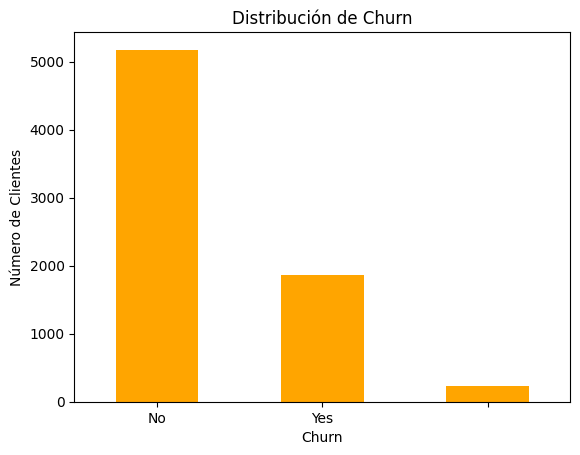

In [ ]:
import matplotlib.pyplot as plt

counts = df['Churn'].value_counts()
plt.figure()
counts.plot(kind='bar', color='orange')
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=0)
plt.show()


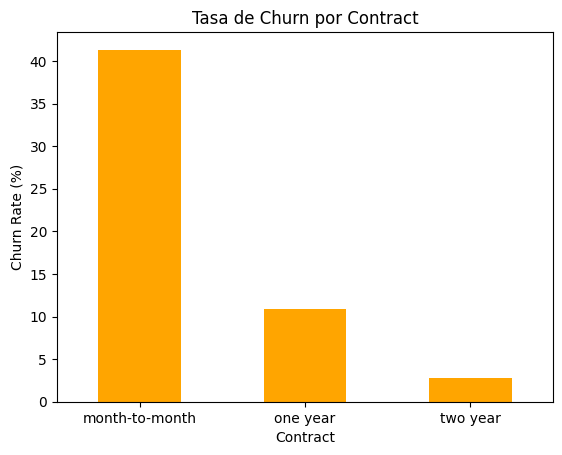

In [ ]:
# Tasa de churn por tipo de contrato
churn_rate_contract = df.groupby('account.Contract')['Churn'] \
    .apply(lambda x: (x == 'Yes').mean() * 100)
plt.figure()
churn_rate_contract.plot(kind='bar', color='orange')
plt.title('Tasa de Churn por Contract')
plt.xlabel('Contract')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=0)
plt.show()


### 2.2 Distribución de Variables Numéricas vs Churn
- **Tenure**: compara la distribución de meses de permanencia.
- **Total Charges**: compara el gasto total acumulado.


/tmp/ipython-input-23-2326907900.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tenure_no, tenure_yes], labels=['No', 'Yes'])


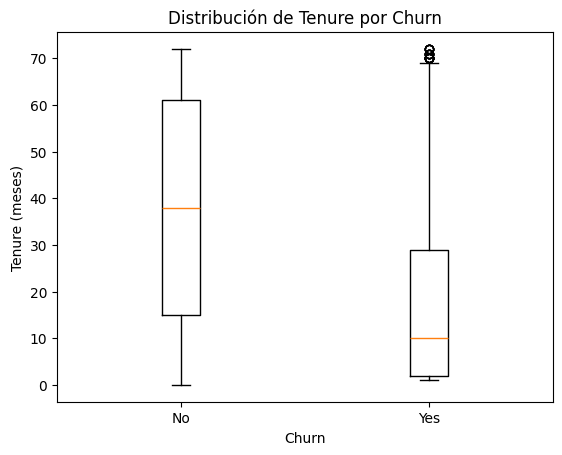

In [ ]:
# Boxplot de Tenure vs Churn
tenure_no  = df[df['Churn']=='No']['customer.tenure'].dropna()
tenure_yes = df[df['Churn']=='Yes']['customer.tenure'].dropna()

plt.figure()
plt.boxplot([tenure_no, tenure_yes], labels=['No', 'Yes'])
plt.title('Distribución de Tenure por Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (meses)')
plt.show()


/tmp/ipython-input-24-1260196611.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([total_no, total_yes], labels=['No', 'Yes'])


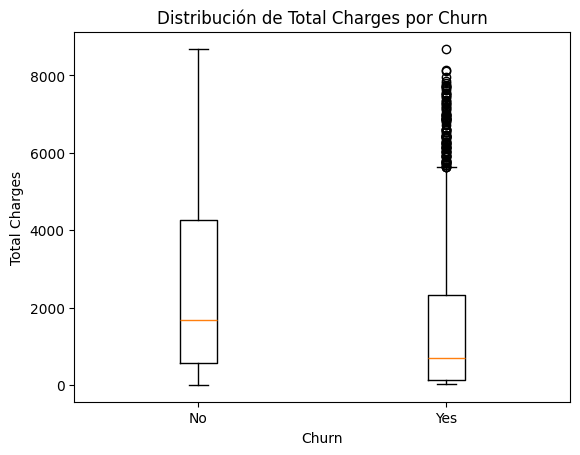

In [ ]:
# Boxplot de Total Charges vs Churn
total_no  = df[df['Churn']=='No']['account.Charges.Total'].dropna()
total_yes = df[df['Churn']=='Yes']['account.Charges.Total'].dropna()

plt.figure()
plt.boxplot([total_no, total_yes], labels=['No', 'Yes'])
plt.title('Distribución de Total Charges por Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()


## 3. Conclusiones e Insights
- **Antigüedad**: la mediana de tenure es ~38 meses en “No” vs ~10 meses en “Yes”.  
- **Contrato**: clientes mes a mes presentan ~41% de churn, muy superior a contratos anuales o bienales.  
- **Método de pago**: cheque electrónico (~44%) es el que más churn muestra.  
- **Gasto Total**: menores cargos acumulados se asocian a churn.


## 4. Recomendaciones Estratégicas
1. **Incentivar renovaciones**: ofertas especiales y descuentos para contratos mes a mes.  
2. **Promover pagos automáticos**: transferencias bancarias o tarjetas de crédito para reducir churn.  
3. **Onboarding reforzado**: acompañamiento y soporte extra durante los primeros 3 meses.  
4. **Programas de fidelización**: descuentos escalonados según antigüedad del cliente.
